This code is taken from a chapter in [The FEniCS Book](https://fenicsproject.org/book/), which is available for free online.
That chapter is in turn an implementation of a model setup from [van Keken et al (1997)](https://doi.org/10.1029/97JB01353).
I took the thermomechanical parts and removed the chemistry.
This paper and the code from the FEniCS book all use a non-dimensional form of the equations, which I've adopted here.

In this notebook, we'll see the Stokes equations again, but we'll couple them to the evolution of temperature through an advection-diffusion equation.
The extensive quantity is not the temperature itself but the internal energy density $E = \rho c_p T$ where $\rho$, $c_p$ are the mass density and the specific heat at constant pressure.
The flux of heat is
$$F = \rho c_p T u - k\nabla T.$$
We'll assume there are no heat sources but, but the real physics would include sources from decay of radioactive elements, strain heating, and chemical reactions.
The variational form of the heat equation is:
$$\int_\Omega\left\{\partial_t(\rho c_p T)\,\phi - (\rho c_p Tu - k\nabla T)\cdot\nabla\phi - Q\phi\right\}dx = 0$$
for all test functions $\phi$.
I've written this in such a way that it still makes sense when the density and heat capacity aren't constant.
We'll assume they are (mostly) constant in the following.
The variational form of the momentum balance equation is
$$\int_\Omega\left\{2\mu\varepsilon(u): \dot\varepsilon(v) - p\nabla\cdot v - q\nabla\cdot u - \rho g\cdot v\right\}dx = 0$$
for all velocity and pressure test functions $v$, $q$.

The characteristic that makes this problem interesting is that we assume the flow is just barely compressible.
This is called the [Boussinesq approximation](https://en.wikipedia.org/wiki/Boussinesq_approximation_(buoyancy)).
In practice, it means we do two apparently contradictory things.
First, we assume that the flow is incompressible:
$$\nabla\cdot u = 0.$$
Second, we assume that the density that we use on the right-hand side of the momentum balance equation actually is compressible, and that the degree of compression is linear in the temperature:
$$\rho = \rho_0(1 - \beta(T - T_0))$$
where $\rho_0$ is a reference density and $\beta$ is thermal expansion coefficient.
These assumptions aren't consistent with each other.
We're also not consistent in using this everywhere.
For example, we only use this expression on the right-hand side of the momentum balance equation, but we'll still take the internal energy density to be equal to $\rho_0c_pT$ in the energy equation.
In other words, the material is compressible as far as momentum balance is concerned but not energy balance.
I find that uncomfortable.
But I would find writing a full compressible solver to be blinding agony.
Anyway it lets us make pretty pictures.

I won't go into a full non-dimensionalization of the problem, which is detailed in the van Keken paper.
The most important dimensionless numbers for this system are the [Prandtl number](https://en.wikipedia.org/wiki/Prandtl_number) and the [Rayleigh number](https://en.wikipedia.org/wiki/Rayleigh_number).
The Prandtl number quantifies the ratio of momentum diffusivity to thermal diffusivity:
$$\text{Pr} = \frac{\mu / \rho}{k / \rho c_p} = \frac{\nu}{\kappa}$$
where $\nu$ and $\kappa$ are respectively the kinematic viscosity and thermal diffusivity.
For mantle flows, the Prandtl number is on the order of $10^{25}$.
We can get a sense for a characteristic velocity scale from the momentum balance equation.
First, we can take a factor of $\rho_0g$ into the pressure.
If we take $U$, $L$, and $\Delta T$ to be the characteristic velocity, length, and temperature difference scales, non-dimensionalizing the momentum balance equation gives
$$\frac{\mu U}{L^2} \approx \rho_0g\beta\Delta T$$
which then implies that $U = \rho_0g\beta L^2\Delta T / \mu$.
Now we can compute the thermal Péclet number
$$\text{Pe} = \frac{UL}{\kappa}.$$
When the Péclet number is large, we're in the convection-dominated regime; when it's small, we're in the diffusion-dominated regime.
Taking our estimate of velocity scale from before, we get
$$\text{Pe} = \frac{\rho_0 g \beta L^3 \Delta T}{\kappa\mu}.$$
This is identical to the Rayleigh number, which we'll write as $\text{Ra}$.
Lord Rayleigh famously used linear stability analysis to show that a fluid that is heated from below and cooled from above is unstable when the Rayleigh number exceeds 600 or so.
Here we'll take the Rayleigh number to be equal to $10^6$ as in the van Keken paper.
It's a worthwhile exercise in numerical analysis to see what it takes to make a solver go for higher values of the Rayleigh number.

Here we're using a rectangular domain.
Again, the spatial scales have been non-dimensionalized.

In [1]:
import numpy as np
from numpy import pi as π
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm.notebook import trange, tqdm
import firedrake
from firedrake import (
    Constant, sqrt, exp, min_value, max_value, inner, sym, grad, div, dx
)
import irksome
from irksome import Dt

Lx, Ly = Constant(2.0), Constant(1.0)
ny = 32
nx = int(float(Lx / Ly)) * ny
mesh = firedrake.RectangleMesh(
    nx, ny, float(Lx), float(Ly), diagonal="crossed"
)

The initial condition for temperature involves loads of annoyingly long expressions, but it's all in Appendix A of the van Keken paper.

In [2]:
def clamp(z, zmin, zmax):
    return min_value(Constant(zmax), max_value(Constant(zmin), z))

def switch(z):
    return exp(z) / (exp(z) + exp(-z))

Ra = Constant(1e6)

ϵ = Constant(1 / nx)
x = firedrake.SpatialCoordinate(mesh)

q = Lx**(7 / 3) / (1 + Lx**4)**(2 / 3) * (Ra / (2 * np.sqrt(π)))**(2/3)
Q = 2 * sqrt(Lx / (π * q))
T_u = 0.5 * switch((1 - x[1]) / 2 * sqrt(q / (x[0] + ϵ)))
T_l = 1 - 0.5 * switch(x[1] / 2 * sqrt(q / (Lx - x[0] + ϵ)))
T_r = 0.5 + Q / (2 * np.sqrt(π)) * sqrt(q / (x[1] + 1)) * exp(-x[0]**2 * q / (4 * x[1] + 4))
T_s = 0.5 - Q / (2 * np.sqrt(π)) * sqrt(q / (2 - x[1])) * exp(-(Lx - x[0])**2 * q / (8 - 4 * x[1]))
expr = T_u + T_l + T_r + T_s - Constant(1.5)

degree = 1
temperature_space = firedrake.FunctionSpace(mesh, "CG", degree)
T_0 = firedrake.Function(temperature_space).interpolate(clamp(expr, 0, 1))
T = T_0.copy(deepcopy=True)

The important point is to make the fluid hotter below and on one side and cooler above and on the other side, shown in the plot below.

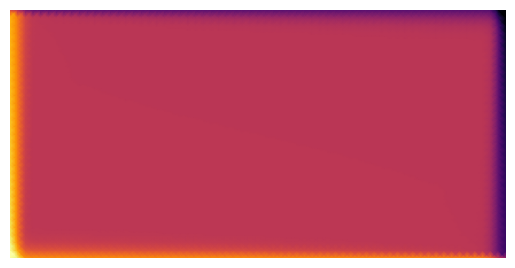

In [3]:
def subplots():
    fig, axes = plt.subplots()
    axes.set_aspect("equal")
    axes.set_axis_off()
    axes.set_xlim(0, float(Lx))
    axes.set_ylim(0, float(Ly))
    return fig, axes

fig, axes = subplots()
firedrake.tripcolor(T, cmap="inferno", axes=axes);

Next we need to make some function spaces for the fluid velocity and pressure.
Note how the degree of the velocity space is one higher than that of the pressure -- we're using the Taylor-Hood element again.

In [4]:
pressure_space = firedrake.FunctionSpace(mesh, "CG", 1)
velocity_space = firedrake.VectorFunctionSpace(mesh, "CG", 2)
Z = velocity_space * pressure_space

Once we've created a function in the mixed space, we can then pull out the two parts with the `split` method.

In [5]:
z = firedrake.Function(Z)
u, p = firedrake.split(z)

The code below creates the variational form of the Stokes equations
$$\nabla\cdot\tau - \nabla p + \text{Ra}\;T\; g = 0$$
with temperature-dependent gravitational forcing.

In [6]:
μ = Constant(1)
ε = lambda u: sym(grad(u))

v, q = firedrake.TestFunctions(z.function_space())

τ = 2 * μ * ε(u)
g = Constant((0, -1))
f = -Ra * T * g
F = (inner(τ, ε(v)) - q * div(u) - p * div(v) - inner(f, v)) * dx

We can use the `.sub` method to pull parts out of mixed spaces, which we need in order to create the right boundary conditions.

In [7]:
bc = firedrake.DirichletBC(Z.sub(0), Constant((0, 0)), "on_boundary")

A bit of magic in order to tell the linear solver that the Stokes equations have a null space we need to project out.

In [8]:
basis = firedrake.VectorSpaceBasis(constant=True, comm=firedrake.COMM_WORLD)
nullspace = firedrake.MixedVectorSpaceBasis(Z, [Z.sub(0), basis])

Here I'm creating solver object since we'll need to repeatedly solve the same system many times.

In [9]:
stokes_problem = firedrake.NonlinearVariationalProblem(F, z, bc)
parameters = {
    "nullspace": nullspace,
    "solver_parameters": {
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
}
stokes_solver = firedrake.NonlinearVariationalSolver(stokes_problem, **parameters)

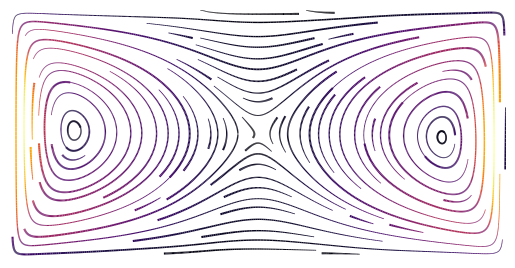

In [10]:
stokes_solver.solve()
fig, axes = subplots()
firedrake.streamplot(
    z.sub(0), axes=axes, resolution=1/40, cmap="inferno", seed=1729
);

Here we're setting up the temperature solver, which includes both convection and diffusion.
I've set the timestep based on the mesh size and the maximum speed that we just found above from the velocity solution.

In [11]:
ρ, c, k = Constant(1), Constant(1), Constant(1)
δx = mesh.cell_sizes.dat.data_ro[:].min()
umax = z.sub(0).dat.data_ro[:].max()
δt = Constant(δx / umax)

ϕ = firedrake.TestFunction(temperature_space)
f = ρ * c * T * u - k * grad(T)
G = (ρ * c * Dt(T) * ϕ - inner(f, grad(ϕ))) * dx

lower_bc = firedrake.DirichletBC(temperature_space, 1, [3])
upper_bc = firedrake.DirichletBC(temperature_space, 0, [4])
bcs = [lower_bc, upper_bc]

method = irksome.BackwardEuler()
temperature_solver = irksome.TimeStepper(G, method, Constant(0.0), δt, T, bcs=bcs)

In [12]:
print(f"Timestep: {float(δt):0.03g}")

Timestep: 0.000132


And the timestepping loop.
Note that the final time is on a non-dimensional scale again, in physical time it works out to be on the order of a hundred million years.
Here we're using an operator splitting approach.
We first update the temperature, and then we compute a new velocity and pressure.
The splitting error goes like $\mathscr{O}(\delta t)$ as the timestep is reduced.
So if we use a first-order integration scheme like backward Euler then the splitting error is asymptotically the same as that of the discretization itself.
We could get $\mathscr{O}(\delta t^3)$ or higher convergence by using, say, the Radau-IIA method, but the total error would be dominated by splitting, so there would be little point in trying harder.

In [13]:
final_time = 0.25
num_steps = int(final_time / float(δt))
Ts = [T.copy(deepcopy=True)]
zs = [z.copy(deepcopy=True)]

for step in trange(num_steps):
    temperature_solver.advance()
    stokes_solver.solve()

    Ts.append(T.copy(deepcopy=True))
    zs.append(z.copy(deepcopy=True))

  0%|          | 0/1893 [00:00<?, ?it/s]

The movie below shows the temperature evolution.
The rising and sinking plumes of hot and cold fluid correspond to the [mantle plumes](https://en.wikipedia.org/wiki/Mantle_plume) that produce surface volcanism.

In [14]:
%%capture
fig, axes = subplots()
kw = {"num_sample_points": 4, "vmin": 0, "vmax": 1, "cmap": "inferno"}
colors = firedrake.tripcolor(Ts[0], axes=axes, **kw)

In [15]:
fn_plotter = firedrake.FunctionPlotter(mesh, num_sample_points=4)
animate = lambda T: colors.set_array(fn_plotter(T))
animation = FuncAnimation(fig, animate, frames=tqdm(Ts), interval=1e3/30)

  0%|          | 0/1894 [00:00<?, ?it/s]

In [16]:
HTML(animation.to_html5_video())

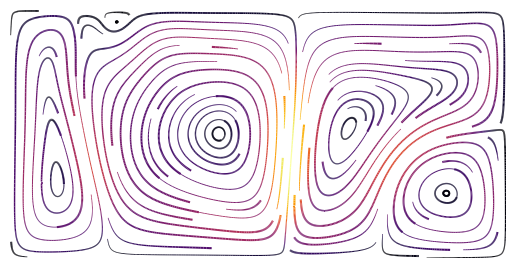

In [17]:
z = zs[-1]
u, p = z.subfunctions
fig, axes = subplots()
firedrake.streamplot(
    u, axes=axes, resolution=1/40, cmap="inferno", seed=1729
);

### What next

There are a few features in the van Keken paper and otherwise that I didn't attempt here.
The original van Keken paper adds chemistry.
Solving the associated species transport equation with as little numerical diffusion as possible is hard.
You could then make the fluid buoyancy depend on chemical composition and add temperature-dependent chemical reactions.

Real mantle fluid also has a temperature-dependent viscosity.
When I tried to add this using the splitting scheme above, the solver quickly diverges.
Getting that to work might require a fully coupled time-integration scheme, which I did try.
Rather than split up the temperature and the velocity/pressure solves, a fully coupled scheme would solve for all three fields at once.
If you could make this work, it would open up the possibility of using higher-order methods like Radau-IIA.
Whether it would go or not seemed to depend on the machine and the day of the week.
I'll explore that more in a future post.